### Import all the libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
!pip install torch-summary==1.4.4 # for DenseNet121
from torchvision import models
from torchsummary import summary

import numpy as np 
from matplotlib import pyplot as plt 
import matplotlib.ticker as mticker

import pandas as pd
from sklearn.metrics import classification_report

import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import sys

sys.path.append('/kaggle/input/myscripts/tensorflow2/default/1')

import prototypical_network
import train_and_evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Preprocessing the images

In [3]:
def check_image_path(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

def random_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    alpha = random.uniform(*alpha_range)  # Random contrast factor
    beta = random.randint(*beta_range)  # Random brightness factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Convert to grayscale for CLAHE
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_image = clahe.apply(gray_image)
    
    # Convert back to 3-channel format for consistency
    enhanced_image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    return enhanced_image_rgb

def display_image_comparison(original_image, enhanced_image):
    # Plotting the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Original Image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes
    # Enhanced Image
    axes[1].imshow(enhanced_image)
    axes[1].set_title("Image after CLAHE")
    axes[1].axis('off')  # Hide axes
    # Show the plot
    plt.show()

def read_xray_images(directory_path, img_height, img_width, selected_classes=None, augmentation=False, 
                     normalize=False, apply_clahe_flag=True, display_comparison=False):
    """
    Read X-ray images from specified classes.
    
    Args:
        directory_path (str): Path to the main directory containing class subdirectories
        img_height (int): Desired height for resized images
        img_width (int): Desired width for resized images
        selected_classes (list): List of class names to load. If None, loads all classes
        augmentation (bool): Whether to apply data augmentation
        normalize (bool): Whether to normalize pixel values to [0,1]
        apply_clahe_flag (bool): Whether to apply CLAHE enhancement
        display_comparison (bool): Whether to display original vs enhanced images
    
    Returns:
        tuple: (np.array of images, np.array of labels)
    """
    datax = [] 
    datay = [] 
    
    # Get available classes
    sub_directories = os.listdir(directory_path)
    
    # If no specific classes are selected, use all available classes
    if selected_classes is None:
        selected_classes = sub_directories
    else:
        # Verify all requested classes exist
        for cls in selected_classes:
            if cls not in sub_directories:
                raise ValueError(f"Class '{cls}' not found in {directory_path}. Available classes: {sub_directories}")
    
    # Only process selected classes
    for sub_dir in selected_classes:
        sub_dir_path = os.path.join(directory_path, sub_dir)
        correct_image_filepaths = check_image_path(sub_dir_path)
        
        for fpath in correct_image_filepaths:
            image = cv2.imread(fpath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))
            
            if apply_clahe_flag:
                enhanced_image = apply_clahe(image)
                image = enhanced_image  # Use the enhanced image
            
            if augmentation:
                image = random_brightness_contrast(image)
                if random.random() < 0.5:  # 50% chance to rotate
                    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            
            if normalize:
                image = image / 255.0  # Normalize pixel values to [0, 1]
                
            if display_comparison:
                display_image_comparison(image, enhanced_image)
                
            datax.append(image)
            datay.append(sub_dir)
    
    return np.array(datax), np.array(datay)

### Download pre-trained model

In [4]:
resnet50_model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


### Model architecture

In [5]:
resnet50_model = resnet50_model.to(device)
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Summarize model

In [6]:
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

### Model layers and their child modules

In [7]:
for name, module in resnet50_model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [8]:
print(f"---Main modules---")
for name, module in resnet50_model.named_children():
    print(name)
    
print(f"---Child Modules for the 'layer4' module")
for name, module in resnet50_model.named_children():
    if name == "layer4":
        for n, m in module.named_children():
            print(n)

---Main modules---
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
---Child Modules for the 'layer4' module
0
1
2


In [9]:
for param in resnet50_model.parameters():
    param.requires_grad = False

### Flatten outputs from the Convolutional base networks and remove the Linear layers

In [10]:
resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

### Unfreeze the layers you want for fine-tuning

In [11]:
for param in resnet50_model.layer4[2:].parameters():
    param.requires_grad = True

In [12]:
summary(resnet50_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [13]:
img_height, img_width = 224, 224 
train_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Training"
validation_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Validation"
test_data_dir = r"/kaggle/input/thoraric-disease-dataset/Few Shot Algorithm/Testing"

In [14]:
%%time
train_data_dir = train_data_dir
x_train, y_train = read_xray_images(train_data_dir, img_height, img_width, augmentation=True)
x_train.shape, y_train.shape

CPU times: user 1.13 s, sys: 326 ms, total: 1.46 s
Wall time: 1.56 s


((60, 224, 224, 3), (60,))

In [15]:
validation_data_dir = validation_data_dir
x_val, y_val = read_xray_images(validation_data_dir, img_height, img_width, augmentation=True)
x_val.shape, x_val.shape

((60, 224, 224, 3), (60, 224, 224, 3))

### Display Sample Images

Class labels sampled: ['Cardiomegaly' 'Atelectasis']


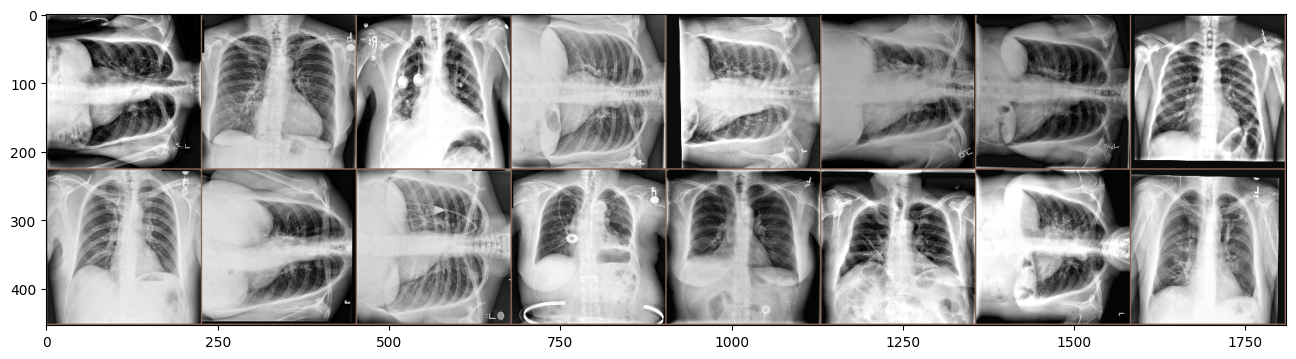

In [16]:
n_way = 2     
n_support = 5 
n_query = 3   
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_train, y_train)
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

### Train a Prototypical Network using a fine-tuned base model

In [17]:
model = prototypical_network.ProtoNet(resnet50_model, device)
model.to(device)

basic_learning_rate = 0.0005

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=basic_learning_rate/10)

n_way = 2       
n_support = 3   
n_query = 10

validation_episodes = 20
train_episodes = 20

max_epoch = 20

filename = "ResNettrain-best-few-shot-model-2-way-3-shot.pt"

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = train_and_evaluation.run_training_and_evaluation(model, x_train, y_train, x_val, y_val, n_way, n_support, n_query, train_episodes, validation_episodes, optimizer, max_epoch, filename)

average_train_accuracy = sum(train_accuracy_list) / len(train_accuracy_list)
average_validation_accuracy = sum(validation_accuracy_list) / len(validation_accuracy_list)


print(f"Average Training Accuracy: {average_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {average_validation_accuracy:.2f}%")

Start training: 


Epoch 1 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1
	Train Loss: 7.842 | Train Acc: 63.50%
	 Val. Loss: 12.209 | Val. Acc: 60.00%


Epoch 2 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 2
	Train Loss: 1.589 | Train Acc: 84.50%
	 Val. Loss: 10.913 | Val. Acc: 67.25%


Epoch 3 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 3
	Train Loss: 0.879 | Train Acc: 91.50%
	 Val. Loss: 9.025 | Val. Acc: 57.50%


Epoch 4 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 4
	Train Loss: 0.580 | Train Acc: 93.50%
	 Val. Loss: 10.723 | Val. Acc: 53.75%


Epoch 5 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 5
	Train Loss: 0.760 | Train Acc: 94.50%
	 Val. Loss: 11.296 | Val. Acc: 54.50%


Epoch 6 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 6
	Train Loss: 0.495 | Train Acc: 94.50%
	 Val. Loss: 11.554 | Val. Acc: 53.25%


Epoch 7 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 7
	Train Loss: 0.540 | Train Acc: 93.75%
	 Val. Loss: 10.195 | Val. Acc: 54.75%


Epoch 8 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 8
	Train Loss: 0.383 | Train Acc: 95.75%
	 Val. Loss: 10.062 | Val. Acc: 55.75%


Epoch 9 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 9
	Train Loss: 0.942 | Train Acc: 93.00%
	 Val. Loss: 10.960 | Val. Acc: 51.50%


Epoch 10 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 10
	Train Loss: 0.700 | Train Acc: 94.00%
	 Val. Loss: 9.615 | Val. Acc: 51.00%


Epoch 11 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 11
	Train Loss: 0.461 | Train Acc: 96.25%
	 Val. Loss: 11.372 | Val. Acc: 54.00%


Epoch 12 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 12
	Train Loss: 0.319 | Train Acc: 97.00%
	 Val. Loss: 9.201 | Val. Acc: 52.50%


Epoch 13 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 13
	Train Loss: 0.526 | Train Acc: 95.50%
	 Val. Loss: 10.082 | Val. Acc: 55.25%


Epoch 14 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 14
	Train Loss: 0.452 | Train Acc: 96.00%
	 Val. Loss: 11.877 | Val. Acc: 56.50%


Epoch 15 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 15
	Train Loss: 0.225 | Train Acc: 96.25%
	 Val. Loss: 9.831 | Val. Acc: 57.75%


Epoch 16 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 16
	Train Loss: 0.808 | Train Acc: 93.00%
	 Val. Loss: 10.630 | Val. Acc: 58.50%


Epoch 17 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 17
	Train Loss: 0.530 | Train Acc: 95.25%
	 Val. Loss: 10.434 | Val. Acc: 52.75%


Epoch 18 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 18
	Train Loss: 0.607 | Train Acc: 94.50%
	 Val. Loss: 10.548 | Val. Acc: 55.25%


Epoch 19 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 19
	Train Loss: 0.388 | Train Acc: 95.50%
	 Val. Loss: 11.153 | Val. Acc: 51.00%


Epoch 20 train:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 validation:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 20
	Train Loss: 0.278 | Train Acc: 97.50%
	 Val. Loss: 9.409 | Val. Acc: 55.50%
Average Training Accuracy: 0.93%
Average Validation Accuracy: 0.55%


In [19]:
results = {
    "Epoch": list(range(1, max_epoch + 1)),
    "Train Loss": train_loss_list,
    "Train Accuracy": train_accuracy_list,
    "Validation Loss": validation_loss_list,
    "Validation Accuracy": validation_accuracy_list
}

df = pd.DataFrame(results)

df.to_csv("/kaggle/working/resnet_training_results.csv", index=False)

df.to_pickle("/kaggle/working/resnet_training_results.pkl")
results = {
    "Epoch": list(range(1, max_epoch + 1)),
    "Train Loss": train_loss_list,
    "Train Accuracy": train_accuracy_list,
    "Validation Loss": validation_loss_list,
    "Validation Accuracy": validation_accuracy_list
}

In [20]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)

### 2 Way 3 Shot ResNet Testing

In [21]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 3
n_query = 10

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 8.696, Accuracy: 0.80
Episode: 100 ---> Loss: 4.374, Accuracy: 0.75
Episode: 200 ---> Loss: 0.001, Accuracy: 1.00
Episode: 300 ---> Loss: 1.972, Accuracy: 0.75
Episode: 400 ---> Loss: 1.243, Accuracy: 0.85
Episode: 500 ---> Loss: 4.412, Accuracy: 0.75
Episode: 600 ---> Loss: 2.250, Accuracy: 0.80
Episode: 700 ---> Loss: 2.772, Accuracy: 0.85
Episode: 800 ---> Loss: 0.910, Accuracy: 0.95
Episode: 900 ---> Loss: 2.447, Accuracy: 0.80
Episode: 1000 ---> Loss: 3.446, Accuracy: 0.85
Episode: 1100 ---> Loss: 6.518, Accuracy: 0.70
Episode: 1200 ---> Loss: 4.060, Accuracy: 0.85
Episode: 1300 ---> Loss: 4.024, Accuracy: 0.80
Episode: 1400 ---> Loss: 8.451, Accuracy: 0.75
Episode: 1500 ---> Loss: 2.987, Accuracy: 0.80
Episode: 1600 ---> Loss: 1.317, Accuracy: 0.90
Episode: 1700 ---> Loss: 4.168, Accuracy: 0.80
Episode: 1800 ---> Loss: 1.790, Accuracy: 0.80
Episode: 1900 ---> Loss: 1.819, Accuracy: 0.80
Episode: 2000 ---> Loss: 0.9

In [22]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}

df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_2way_3shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_3shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_3shot.csv


### 2 Way 3 Shot Prediction

Class labels sampled: ['Effusion' 'Covid19']
{'loss': 14.805170059204102, 'acc': 0.675000011920929, 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]],
       device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]])}


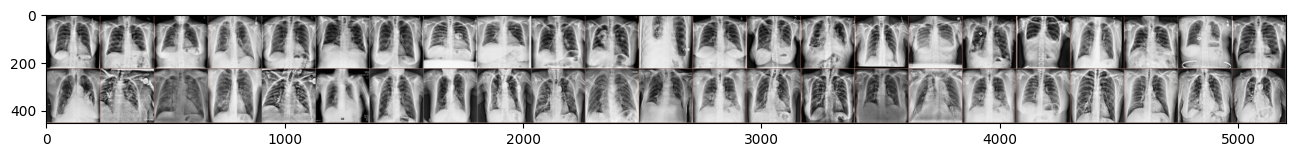

In [23]:
prototypical_model.to(device)
n_way = 2
n_support = 3
n_query = 20 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [24]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data)

df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_2way_3shot.csv', index=False)

print("Results saved to /kaggle/working/prototypical_model_results_resnet_2way_3shot.csv")

Results saved to /kaggle/working/prototypical_model_results_resnet_2way_3shot.csv


### 2 Way 3 Shot Classification Report

In [25]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

    Effusion       0.61      1.00      0.75        20
     Covid19       1.00      0.35      0.52        20

    accuracy                           0.68        40
   macro avg       0.80      0.68      0.64        40
weighted avg       0.80      0.68      0.64        40



### ROC Curve

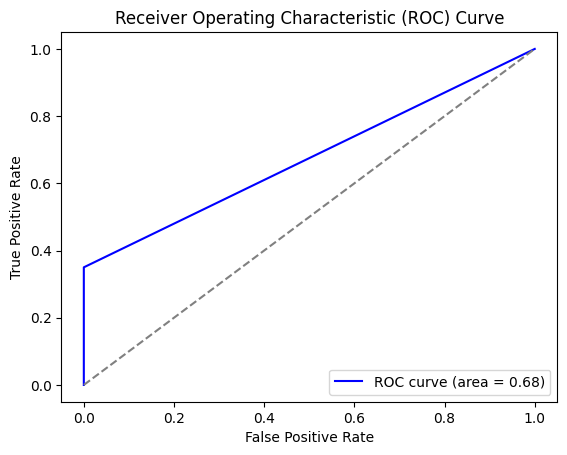

In [26]:
y_true_flat = results["y_true"].flatten() 
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

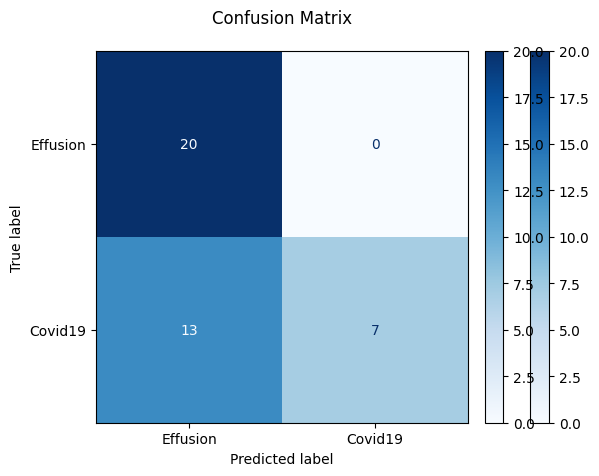

In [27]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 2 Way 5 Shot ResNet Testing

In [28]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 2
n_support = 5
n_query = 20

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 1.400, Accuracy: 0.85
Episode: 100 ---> Loss: 4.643, Accuracy: 0.75
Episode: 200 ---> Loss: 1.962, Accuracy: 0.85
Episode: 300 ---> Loss: 0.587, Accuracy: 0.95
Episode: 400 ---> Loss: 1.280, Accuracy: 0.88
Episode: 500 ---> Loss: 2.207, Accuracy: 0.82
Episode: 600 ---> Loss: 4.176, Accuracy: 0.78
Episode: 700 ---> Loss: 3.768, Accuracy: 0.80
Episode: 800 ---> Loss: 1.995, Accuracy: 0.82
Episode: 900 ---> Loss: 2.293, Accuracy: 0.85
Episode: 1000 ---> Loss: 1.732, Accuracy: 0.90
Episode: 1100 ---> Loss: 1.310, Accuracy: 0.82
Episode: 1200 ---> Loss: 2.334, Accuracy: 0.85
Episode: 1300 ---> Loss: 2.747, Accuracy: 0.88
Episode: 1400 ---> Loss: 0.664, Accuracy: 0.93
Episode: 1500 ---> Loss: 0.551, Accuracy: 0.95
Episode: 1600 ---> Loss: 0.910, Accuracy: 0.88
Episode: 1700 ---> Loss: 1.484, Accuracy: 0.80
Episode: 1800 ---> Loss: 2.750, Accuracy: 0.82
Episode: 1900 ---> Loss: 4.604, Accuracy: 0.68
Episode: 2000 ---> Loss: 3.0

In [29]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}


df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_2way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_5shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_resnet_2way_5shot.csv


### 2 Way 5 Shot Prediction

Class labels sampled: ['Covid19' 'Effusion']
{'loss': 3.3175008296966553, 'acc': 0.824999988079071, 'y_hat': tensor([[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'y_pred': array([[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


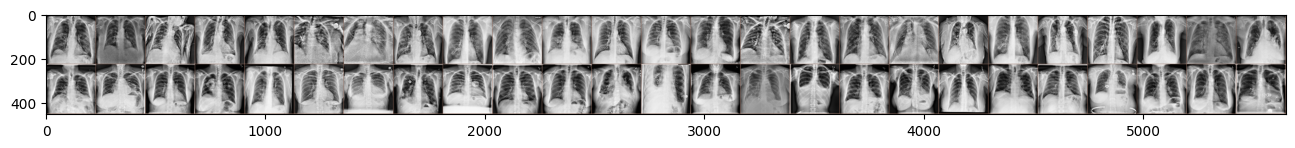

In [30]:
prototypical_model.to(device)
n_way = 2
n_support = 5
n_query = 20 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [31]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data) 


df_results = pd.DataFrame(csv_data)
df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_2way_5shot.csv', index=False)
print("Results saved to /kaggle/working/prototypical_model_results_resnet_2way_5shot.csv")



Results saved to /kaggle/working/prototypical_model_results_resnet_2way_5shot.csv


## 2 way 5 shot Classification Report

In [32]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Covid19       1.00      0.65      0.79        20
    Effusion       0.74      1.00      0.85        20

    accuracy                           0.82        40
   macro avg       0.87      0.82      0.82        40
weighted avg       0.87      0.82      0.82        40



### Plot ROC Curve

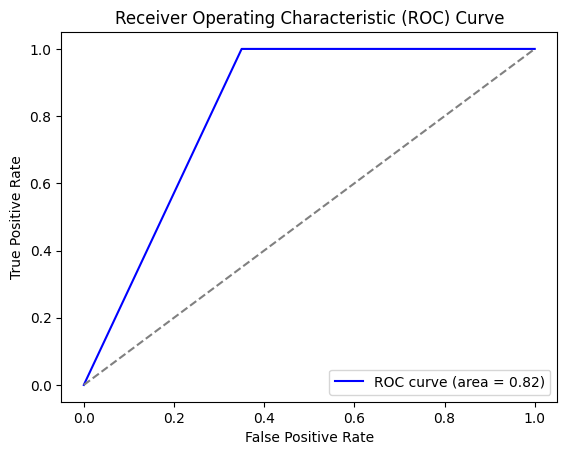

In [33]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

<Figure size 800x600 with 0 Axes>

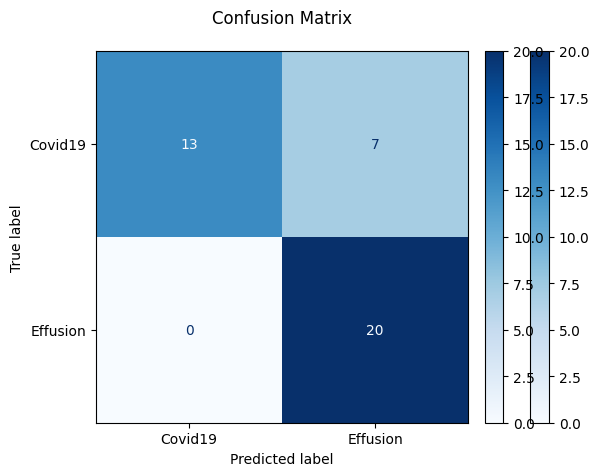

In [34]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### 3 Way 5 Shot ResNet Training

In [36]:
img_height, img_width = 224, 224
data_dir = test_data_dir
selected_classes = ['Covid19', 'Effusion','Pneumonia']

x_test, y_test = read_xray_images(
    data_dir,
    img_height,
    img_width,
    selected_classes=selected_classes,
    augmentation=False
)
x_test.shape,y_test.shape

((90, 224, 224, 3), (90,))

In [37]:
prototypical_model = prototypical_network.ProtoNet(resnet50_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 25

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 5.597, Accuracy: 0.61
Episode: 100 ---> Loss: 7.696, Accuracy: 0.63
Episode: 200 ---> Loss: 6.233, Accuracy: 0.55
Episode: 300 ---> Loss: 5.775, Accuracy: 0.61
Episode: 400 ---> Loss: 5.716, Accuracy: 0.57
Episode: 500 ---> Loss: 4.454, Accuracy: 0.68
Episode: 600 ---> Loss: 4.123, Accuracy: 0.65
Episode: 700 ---> Loss: 8.323, Accuracy: 0.65
Episode: 800 ---> Loss: 5.401, Accuracy: 0.56
Episode: 900 ---> Loss: 4.619, Accuracy: 0.64
Episode: 1000 ---> Loss: 7.573, Accuracy: 0.65
Episode: 1100 ---> Loss: 5.311, Accuracy: 0.64
Episode: 1200 ---> Loss: 4.543, Accuracy: 0.61
Episode: 1300 ---> Loss: 3.904, Accuracy: 0.68
Episode: 1400 ---> Loss: 6.017, Accuracy: 0.69
Episode: 1500 ---> Loss: 6.357, Accuracy: 0.53
Episode: 1600 ---> Loss: 6.875, Accuracy: 0.59
Episode: 1700 ---> Loss: 5.827, Accuracy: 0.65
Episode: 1800 ---> Loss: 10.027, Accuracy: 0.51
Episode: 1900 ---> Loss: 7.605, Accuracy: 0.61
Episode: 2000 ---> Loss: 6.

In [38]:
results = {
    "Test Loss": [test_loss],
    "Test Accuracy (%)": [test_accuracy * 100]
}


df_results = pd.DataFrame(results)
df_results.to_csv('/kaggle/working/prototypical_model_test_results_resnet_3way_5shot.csv', index=False)
print("Test results saved to /kaggle/working/prototypical_model_test_results_resnet_3way_5shot.csv")

Test results saved to /kaggle/working/prototypical_model_test_results_resnet_3way_5shot.csv


### 3 Way 5 Shot ResNet Prediction

Class labels sampled: ['Covid19' 'Effusion' 'Pneumonia']
{'loss': 5.358896255493164, 'acc': 0.6533333659172058, 'y_hat': tensor([[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1,
         1],
        [2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2,
         1]], device='cuda:0'), 'y_true': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2]]), 'y_pred': array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0],
       [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        1, 1, 1],
       [2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2,
        0, 2, 1]])}


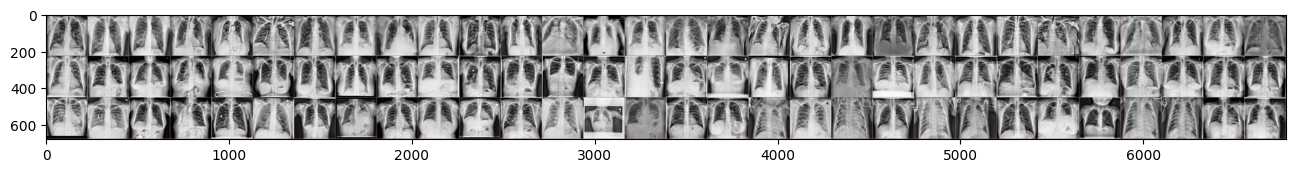

In [39]:
prototypical_model.to(device)
n_way = 3
n_support = 5
n_query = 25 

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")

print(results)

In [40]:
csv_data = {
    "Class Labels": [sample_images['class_labels']] * len(results['y_true'].flatten()),
    "Loss": [results['loss']] * len(results['y_true'].flatten()),
    "Accuracy": [results['acc']] * len(results['y_true'].flatten()),
}


y_true_flat = results['y_true'].flatten()
y_pred_flat = results['y_pred'].flatten()


csv_data["True Class"] = y_true_flat
csv_data["Pred Class"] = y_pred_flat

df_results = pd.DataFrame(csv_data) 


df_results = pd.DataFrame(csv_data)
df_results.to_csv('/kaggle/working/prototypical_model_results_resnet_3way_5shot.csv', index=False)
print("Results saved to /kaggle/working/prototypical_model_results_resnet_3way_5shot.csv")


Results saved to /kaggle/working/prototypical_model_results_resnet_3way_5shot.csv


### Classification Report

In [41]:
y_true_flat = results["y_true"].flatten()
y_pred_flat = results["y_pred"].flatten()


class_labels = sample_images["class_labels"]
label_mapping = {i: label for i, label in enumerate(class_labels)}


report = classification_report(y_true_flat, y_pred_flat, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Covid19       0.95      0.76      0.84        25
    Effusion       0.50      0.76      0.60        25
   Pneumonia       0.65      0.44      0.52        25

    accuracy                           0.65        75
   macro avg       0.70      0.65      0.66        75
weighted avg       0.70      0.65      0.66        75



### Confusion Matrix

<Figure size 800x600 with 0 Axes>

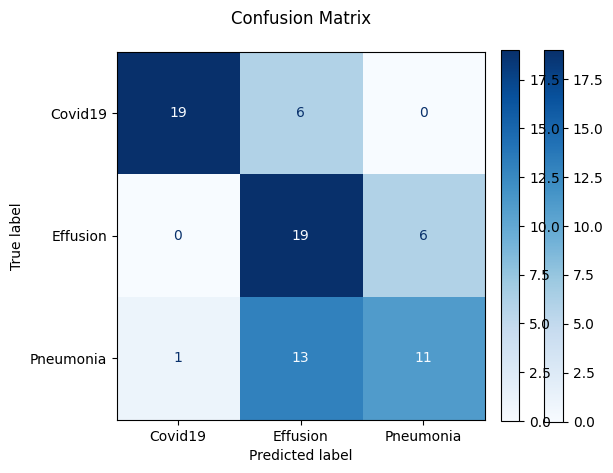

In [42]:
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

cmap = plt.cm.Blues  

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels)
disp.plot(cmap=cmap, values_format='d')


plt.title("Confusion Matrix", fontsize=12, pad=20)
plt.grid(False)

plt.colorbar(disp.im_, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### ROC Curve

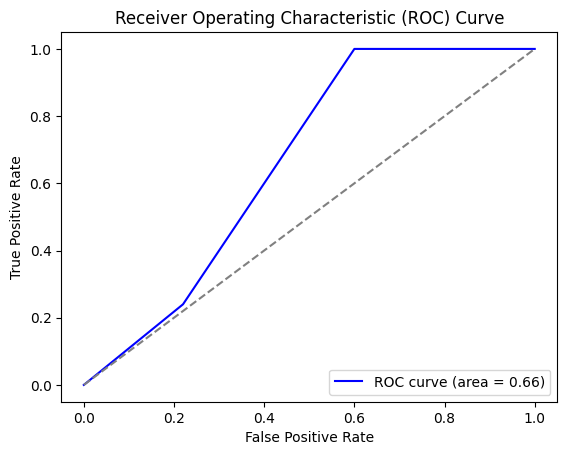

In [43]:
y_true_flat = results["y_true"].flatten()  
y_scores = results["y_pred"].flatten()    


fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()